Slight modification of standard ray trace to generate initial reusable set of 500 launch rays of a solid angle of pi/9, phase = 0, polarization along the +x direction, and shiftable source.

Standardized simple function

see 8/24/19. first digit = 0

Mira Liu 
08/24/2019

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import itertools
from mpl_toolkits.mplot3d import Axes3D
from RayTraceFunctions import * 
from random import uniform
import random
import pickle
import math
import time

In [2]:

'''Same as above but with initial phase of zero instead of random and < lim (solid angle in radians) launch angle. '''
def makerays_Zero_narrow(sourcepointorigin,sourcethet,r,n,lim):
    sourcepoints = specsource(r,sourcepointorigin,sourcethet,n) # SOURCE
    Rays = FSRay_Zero_narrow(n,sourcepoints, sourcethet,origin10,lim)
    return Rays
'''Givin initial rays, just change source (set shift of source point) keeping everything else identical '''
def makerays_Zero_narrow_SetShift(sourcepoint,Rays): 
    spT = [sourcepoint[0],sourcepoint[1],sourcepoint[2]]
    for i in range(len(Rays)): 
        Rays[i][2] = spT
    return Rays
        

'''Simulation of interference of probability function of a single photon. 500 rays with initial phase of zero from a single source point, random launch points, and power is summed before squared. To show Chamberlain loss (large etendue) '''
def RunRays_Prob_narrow_SetRays(Lamd,Nsize,spo,lim,Rays):
    n = 500
    r = 0
    thetG = [0,0,0]
    #Rays = makeraysVERTICAL(spo,r,n) 
    #Rays = makerays_Zero_narrow(spo,thetG,r,n,lim) #lim is solid angle wanted in radians
    #jx,jy = gridlines(7.9375,[160.375,-113],200) #these are now the PIXELS
    #Pix = MakePixels(jx,jy) #center of each pixel
    Ij = []
    Delay = []
    DETECTOR = [] #added to capture final points on detector
    for y in np.linspace(-18,18,int(Nsize)):
        PTot=0
        OutRays=RunRaysM(Rays,y) #all rays that made it to the detector
        #Overlap = gaussoverlap(OutRays[0],OutRays[5],3.3) #two paths that hit two different spots 
        #for j in range(len(Pix)): #per PIXEL
        P = [] #final points on detector.
        for j in range(1): #no pixels
            Ex4i = 0 #adding PER PIXEL from parts of RAYS in this PIXEL
            Ey4i = 0 #THIS IS WHERE THEY WILL INTERFERE
            for i in range(len(OutRays)): #per ray IN THIS PIXEL
                I = OutRays[i][1] #amplitude
                thet = OutRays[i][0] #polarization
                phase = np.exp(1j*(OutRays[i][4]*2*np.pi/Lamd)) #e^ix2pi/lambda, x = distance traveleld
                Ex1 = np.sqrt(I)*np.cos(thet) #polarization
                Ey1 = np.sqrt(I)*np.sin(thet)
                Ex = Ex1*phase #phase
                Ey = Ey1*phase
                #doing summation over entire detector
                #sig,mux,muy = MakeGaussian(OutRays[i],Lamd)
                #Gr = Airygaussian3dNORM(Pix[j][0],Pix[j][1],sig,mux,muy)
                Gr = 1
                Ex4i = Ex4i + Gr*Ex #add electric fields of all rays
                Ey4i = Ey4i + Gr*Ey
                P.append(OutRays[i][2]) #spot on detector.
            PTot = PTot + (Ex4i*Ex4i.conjugate()).real + (Ey4i*Ey4i.conjugate()).real
        Delay.append(y*0.95630475596*4)
        Ij.append(PTot)
        DETECTOR.append(P)
    return Delay,Ij,DETECTOR

def drawcircle(h,k,r):
    x = np.linspace(h-r, h+r, 100)
    ypos = []
    yneg = []
    for i in range(100):
        ypos.append(k + np.sqrt(r**2 - (x[i]-h)**2))
        yneg.append(k - np.sqrt(r**2 - (x[i]-h)**2))
    return x,ypos,yneg
def ZhaodiNumbering(n1,n2,center): #n1n2 in order of zhaodi's numbering
    #mira_center = [-160.375,-113.,-80.0]
    mira_center = center
    mira_axes1 = [10,7.5,5,2.5,0,-2.5,-5,-7.5,-10] #(first number "such as 0 in 04")
    mira_axes2 = [-10,-7.5,-5,-2.5,-0,2.5,5,7.5,10] #(second number "such as 4 in 04")
    mira_shift = mira_center
    mira_shift[0]=mira_center[0]+mira_axes2[n2] #x axis location
    mira_shift[1]=mira_center[1]+mira_axes1[n1] #y axis location
    return mira_shift
def AutomaticShifts(Rays1,n1,n2): #n1 and n1 being between 0 and 8 
    Timei = time.time()
    #print('began: ',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(Timei)))
    print('CURRENTLY RUNNING...', str(n1)+str(n2))
    Lamd =2.089
    #Timei = time.time()
    Nsize = Nsized(Lamd)
    #Nsize = 8192
    Freq = float(300/Lamd)
    spo = [-160.375,-113.,-80.0] #global CENTERED
    spo2 = ZhaodiNumbering(n1,n2,spo) #[-160.375,-113.,-80.0] #global CENTERED
    #lim = np.pi/6 #30 degrees
    #lim= np.pi/9 #20 degrees
    #lim = np.pi/18 #10 degrees

    Rays2 = makerays_Zero_narrow_SetShift(spo2,Rays1) #set rays to spo2!
    Delay1, Ij1,DET = RunRays_Prob_narrow_SetRays(Lamd,Nsize,spo2,np.pi/9,Rays2)

    #Timef = time.time()
    #print('COMPLETED')
    #print('total time: ~',float(Timef-Timei)/60, 'mins')

    with open("Ij_Chamb_144_Narrow_20_x"+str(spo2[0])+'_y'+str(spo2[1])+'_'+str(2.07)+'mm'+time.strftime("_%Y_%m_%d_%H_%M_%S") +'_'+str(n1)+str(n2) +".pkl", "wb") as F:
        pickle.dump(Ij1,F)
    with open("Delay_Chamb_144_Narrow_20_x"+str(spo2[0])+'_y'+str(spo2[1])+'_'+str(2.07)+'mm'+time.strftime("_%Y_%m_%d_%H_%M_%S") +'_'+str(n1)+str(n2)  +".pkl", "wb") as F:
        pickle.dump(Delay1,F)
    with open("Det_Chamb_144_Narrow_20_x"+str(spo2[0])+'_y'+str(spo2[1])+'_'+str(2.07)+'mm'+time.strftime("_%Y_%m_%d_%H_%M_%S") +'_'+str(n1)+str(n2)  +".pkl", "wb") as F:
        pickle.dump(DET,F)
    d1 = Ij1
    D = np.hanning(int(np.shape(d1)[0]))*d1
    S = np.fft.rfft(D)
    #S = S[1:]
    u = np.abs(S)
    xtot = 36*0.95630475596*4 #total length of the scan
    df = 1/xtot
    f = df*np.arange(1+Nsize/2)-df/2

    pl.plot(Delay1,Ij1,linewidth = .8) 
    pl.tick_params(colors = 'black')
    pl.title('$\lambda$='+str(Lamd)+'_' + str(n1) + str(n2),color = 'black')
    pl.xlabel('Optical Delay (mm)', color = 'black')
    pl.savefig('Interferogram_Chamb_144_Narrow_20'+time.strftime("_%Y_%m_%d_%H_%M_%S") +'_'+str(n1)+str(n2)+ '.png')
    pl.show() 

    pl.plot(300*f[3:],u[3:])
    pl.title('Spectrum'+str(n1)+str(n2),color = 'black')
    pl.xlabel('GHz', color = 'black')
    pl.tick_params(colors = 'black')
    pl.axvline(x =float(Freq), color = 'green', label = str(Freq)+'GHz')
    pl.xlim(0,200)
    pl.legend()
    pl.savefig('Spectrum_Chamb_144_Narrow_20'+time.strftime("_%Y_%m_%d_%H_%M_%S") +'_'+str(n1)+str(n2)+ '.png')
    pl.show()

    pl.figure()
    colors = ['r','orange','y','g','c','b','m','k']
    for i in range(8):
        k = int(Nsize/2)+int((Nsize/16)*i)
        for m in range(len(DET[k])): #A certain mirror position
            pl.scatter(DET[k][m][0],DET[k][m][1],color = colors[i],s=1)
            # x and y coordinates of the kth mirror position and mth ray
    pl.plot(xdet,ydetpos,color = 'k')
    pl.plot(xdet,ydetneg,color = 'k')
    pl.savefig('Det_Chamb_144_Narrow_20'+time.strftime("_%Y_%m_%d_%H_%M_%S") +'_'+str(n1)+str(n2)+ '.png')
    pl.show()      

In [3]:
n = 500
r = 0
thetG = [0,0,0]
lim =np.pi/9
spo = [1,1,1] # arbitrary
Lamd =2.089
Nsize = Nsized(Lamd)
Freq = float(300/Lamd)
#Rays1 = makerays_Zero_narrow(spo,thetG,r,n,lim) # initial set of rays
with open('500Rays_Narrow_20__2019_08_24_13_41_38.pkl','rb') as F:
    Rays1 = pickle.load(F)
xdet,ydetpos,ydetneg = drawcircle(160.375, -113, 7.9375) #detector 

CURRENTLY RUNNING... 60


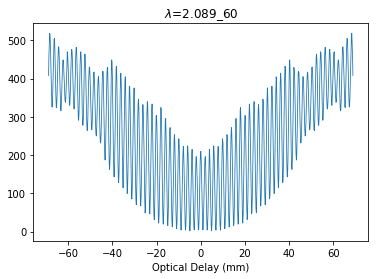

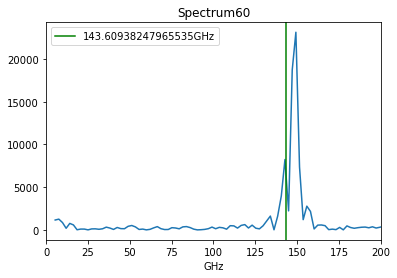

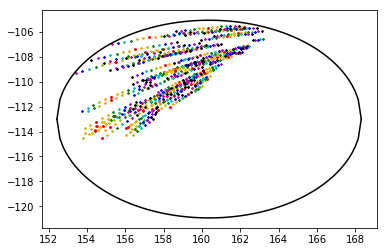

In [4]:
AutomaticShifts(Rays1,6,0)

CURRENTLY RUNNING... 61


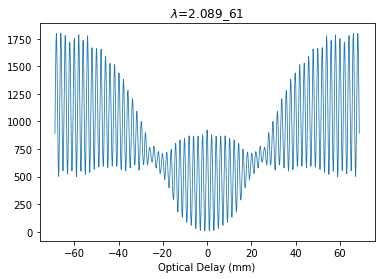

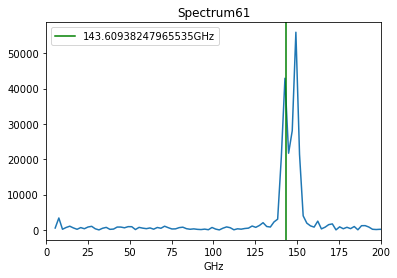

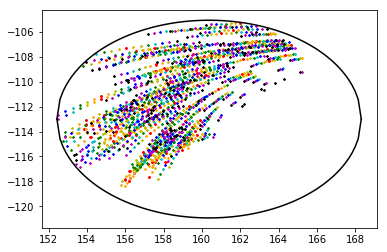

In [5]:
AutomaticShifts(Rays1,6,1)

CURRENTLY RUNNING... 62


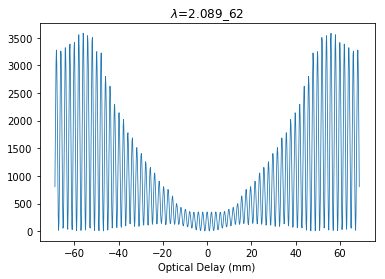

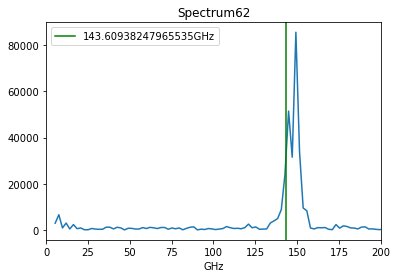

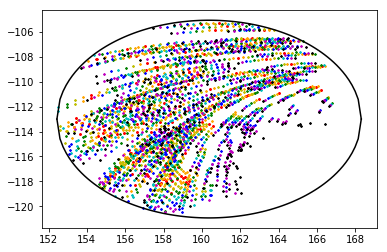

In [6]:
AutomaticShifts(Rays1,6,2)

CURRENTLY RUNNING... 63


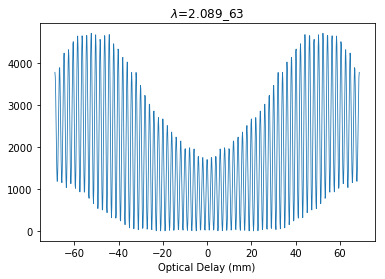

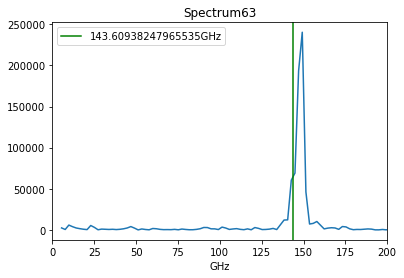

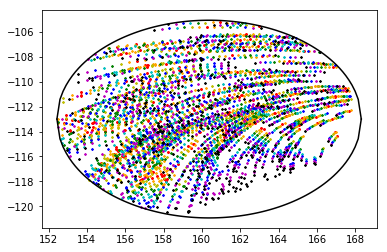

In [7]:
AutomaticShifts(Rays1,6,3)

CURRENTLY RUNNING... 65


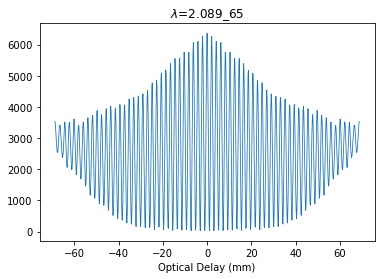

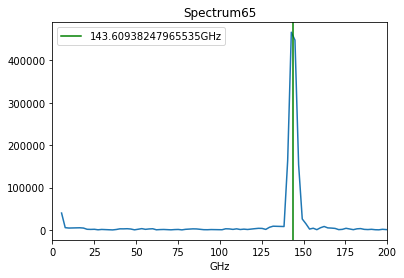

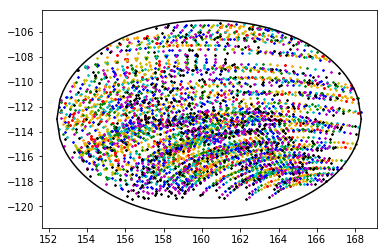

In [8]:
AutomaticShifts(Rays1,6,5)

CURRENTLY RUNNING... 66


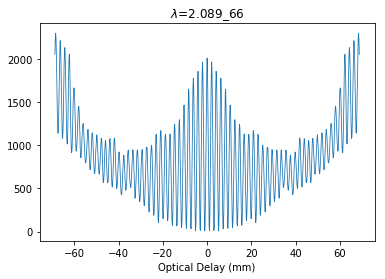

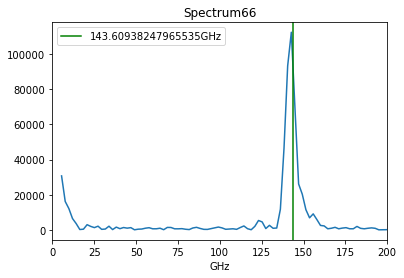

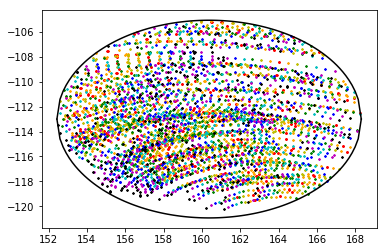

In [9]:
AutomaticShifts(Rays1,6,6)

CURRENTLY RUNNING... 67


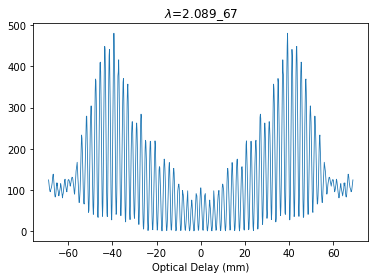

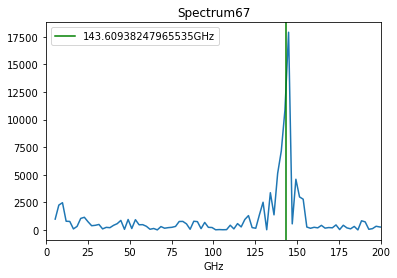

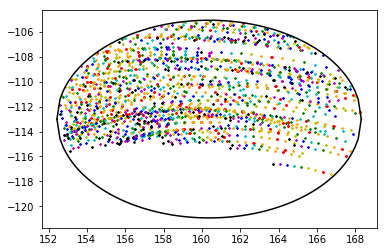

In [10]:
AutomaticShifts(Rays1,6,7)

CURRENTLY RUNNING... 68


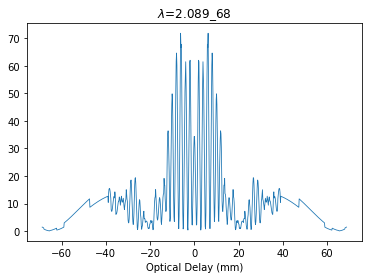

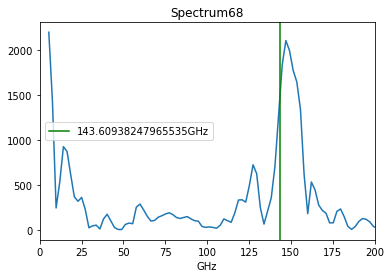

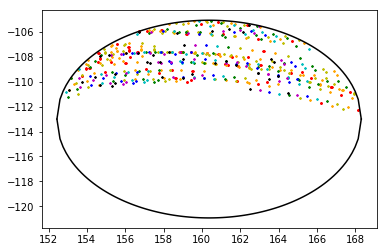

In [11]:
AutomaticShifts(Rays1,6,8)